# Лабораторна робота №3


## Пустовойт Павло КА-98

#### &emsp; Дано два набори даних make_circles та make_blobsм з параметром shuffle=True за замовчуванням, на яких треба дослідити алгоритм AgglomerativeClustering. Алгоритм базується на принципі ієрархічного алгоритму знизу вврех: спочатку відповідно до обраної метрики afinity дані групуються, після чого відповідно до метрики linkage утворюються кластери. Кількість кластерів визначається за допомогою відрізання гілок на певному рівні: на найнищому - буде велика кількість кластерів, що може не відповідати дійсності, на найвищому - єдиний кластер, що також не відповідає дійсності.

In [1]:
from itertools import cycle, islice
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_circles, make_blobs
from sklearn.metrics import pairwise_distances, homogeneity_completeness_v_measure
from sklearn.preprocessing import StandardScaler

n_samples = 500
circles_dataset = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X_circles, y_circles = circles_dataset
circles_dataset_len = len(circles_dataset)
blobs_dataset = make_blobs(n_samples=n_samples, centers=4, cluster_std=1, shuffle=True, random_state=1)
X_blobs, y_blobs = blobs_dataset
blobs_dataset_len = len(blobs_dataset)

#### &emsp; Матриця відстаней будується за допомогою функції *pairwise_distances()*, у яку також передають метрики affinity. 

In [2]:
def matrics_distances(n_clusters, X, y, dataset_name):
    for index, metric in enumerate(["cosine", "euclidean", 'manhattan']):
        avg_dist = np.zeros((n_clusters, n_clusters))
        plt.figure(figsize=(5, 4.5))
        plt.title(f'Pairwise distances for {dataset_name}\n with metric {metric}', size=12)
        for i in range(n_clusters):
            for j in range(n_clusters):
                avg_dist[i, j] = pairwise_distances(
                    X[y == i], X[y == j], metric = metric).mean()
        avg_dist /= avg_dist.max()
        clusters = []
        for i in range(n_clusters):
            clusters.append(f'Cluster {i+1}')
            for j in range(n_clusters):
                plt.text(
                    i,
                    j,
                    "%5.3f" % avg_dist[i, j],
                    verticalalignment="center",
                    horizontalalignment="center",
                )

        plt.imshow(avg_dist, interpolation="nearest", cmap=plt.cm.gnuplot2, vmin=0)
        plt.xticks(range(n_clusters), clusters, rotation=45)
        plt.yticks(range(n_clusters), clusters)
        plt.colorbar()
        #plt.suptitle("Interclass %s distances" % metric, size=18)
        plt.tight_layout()
        #plt.show()

In [3]:
def clustering_view(X, y, len_dataset, n_samples, n_clusters, affinity = 'euclidean'):
        
    #X, y = dataset 
    
    X = StandardScaler().fit_transform(X)

    for index, affinity in enumerate(['cosine', 'euclidean', 'manhattan']):
        
        print(f'For affinity = {affinity}')
        
        plot_num = 1
        plt.figure(figsize=(8 * 1.3 + 2, 8))
        plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)
    
        ward = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage="ward")
        complete = AgglomerativeClustering(n_clusters=n_clusters, affinity = affinity, linkage="complete")
        average = AgglomerativeClustering(n_clusters=n_clusters, affinity = affinity, linkage="average")
        single = AgglomerativeClustering(n_clusters=n_clusters, affinity = affinity, linkage="single")

        clustering_algorithms = (
                ("Single Linkage", single),
                ("Average Linkage", average),
                ("Complete Linkage", complete),
                ("Ward Linkage", ward),
        )
        

        for name, algorithm in clustering_algorithms:

            algorithm.fit(X)

            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)

            plt.subplot(len_dataset, len(clustering_algorithms), plot_num)
            plt.title(name, size=18)

            colors = np.array(
                list(
                    islice(
                        cycle(
                            [
                                "#377eb8",
                                "#ff7f00",
                                "#4daf4a",
                                "#f781bf",
                                "#a65628",
                                "#984ea3",
                                "#999999",
                                "#e41a1c",
                                "#dede00",
                            ]
                        ),
                        int(max(y_pred) + 1),
                    )
                )
            )
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plot_num += 1
            
            scores = homogeneity_completeness_v_measure(y, y_pred)
            est_n_clust = len(np.unique(y_pred))
            print(f"Metrics for {name, affinity}\n Number of Clusters{est_n_clust:-6d}\n Homogeneity {scores[0]:-15f}\n Completeness {scores[1]:-14f}\n V_measure {scores[2]:-17f}\n")
            
        plt.show()
        

#### Метрики відстані та поєднання:
affinity - це функція відстані для поєднання об'єктів. <br>
У роботі використовується три метрики affinity: <br>
&emsp; * cosine - вимірює кут між двома векторами, та використувоється коли величина між точками не має значення, а важлива орієнтація;<br>
&emsp; * euclidean - Евклідова відстань між точками $d(x,y) = \sqrt{\sum(x_i - y_i)^2}$ ;<br>
&emsp; * manhattan - сума абсолютної різниці по всім вимірам, шлях ніби по сітці $\sum|x_i - y_i|$; <br>
linkage - критерій поєднання кластерів.<br>
У роботі використовується чотири критерії linkage:<br>
&emsp; * single - мінімізує відстань між найближчими точками. Тільки для некулястих даних;<br>
&emsp; * average - мінімізує середню відстань між усіма точками. Працює на чітко розподілених даних;<br>
&emsp; * complete - мінімізує максимальну відстань між усіма точками. Працює на чітко розподілених даних;<br>
&emsp; * ward - мінімізує суму квадратів різниць між об'єктами, тому працює тільки з метрикою *euclidean*. Ідеально підходить для зашумлених даних;<br>

#### Метрики якості: отримуються задопомогою функції *homogeneity_completeness_v_measure(y, y_pred)*
&emsp; * Homogeneity (однорідність) - максимальна, якщо кластер складається лише з об'єктів одного класу.<br>
&emsp; * Completeness (повнота) - максимальна, якщо всі об'єкти класу належать до одного певного кластеру.<br>
&emsp; * V_measure - середнє гармонічне Homogeneity та Completeness;

### Для набору make_circles:

For affinity = cosine
Metrics for ('Single Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.001327
 Completeness       0.004152
 V_measure          0.002011

Metrics for ('Average Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000046
 Completeness       0.000046
 V_measure          0.000046

Metrics for ('Complete Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000340
 Completeness       0.000382
 V_measure          0.000360

Metrics for ('Ward Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000775
 Completeness       0.000802
 V_measure          0.000788



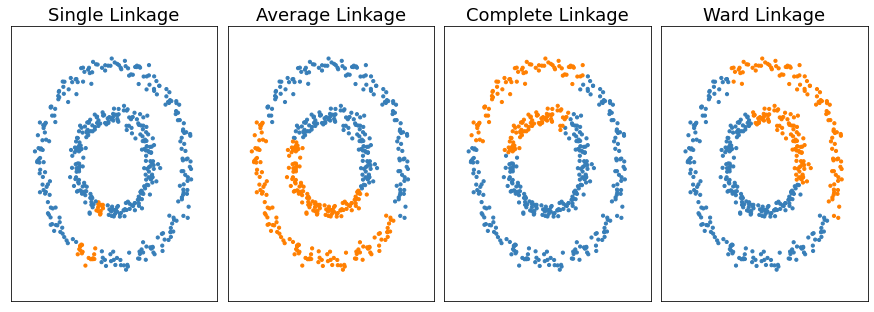

For affinity = euclidean
Metrics for ('Single Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        1.000000
 Completeness       1.000000
 V_measure          1.000000

Metrics for ('Average Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        0.000104
 Completeness       0.000104
 V_measure          0.000104

Metrics for ('Complete Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        0.000571
 Completeness       0.000575
 V_measure          0.000573

Metrics for ('Ward Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        0.000775
 Completeness       0.000802
 V_measure          0.000788



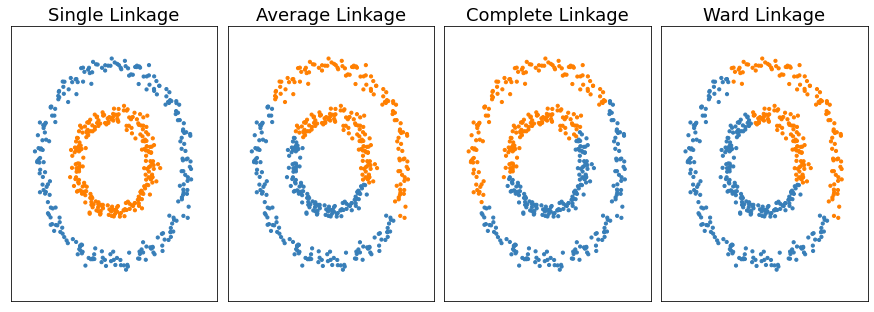

For affinity = manhattan
Metrics for ('Single Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        1.000000
 Completeness       1.000000
 V_measure          1.000000

Metrics for ('Average Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        0.000566
 Completeness       0.000566
 V_measure          0.000566

Metrics for ('Complete Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        0.004849
 Completeness       0.005019
 V_measure          0.004933

Metrics for ('Ward Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        0.000775
 Completeness       0.000802
 V_measure          0.000788



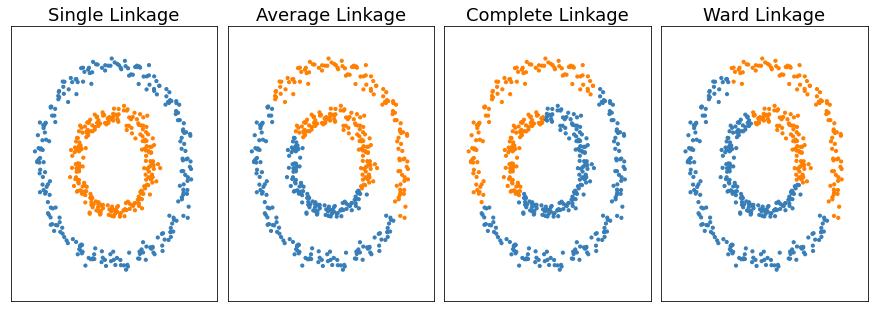

In [4]:
clustering_view(X_circles, y_circles, circles_dataset_len, n_samples, 2)

#### Матриці відстаней для відповідних метрик afinity:

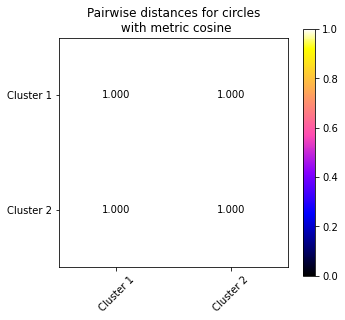

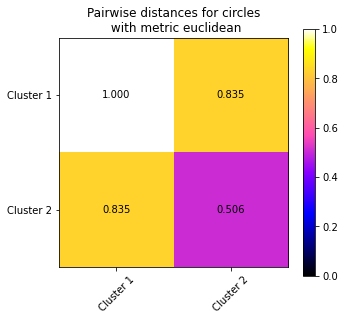

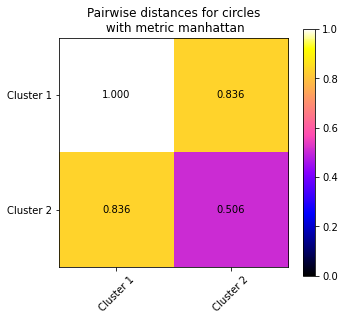

In [5]:
matrics_distances(2, X_circles, y_circles, 'circles')

#### Кластеризація за заданою неправильною кількістю класів - *4*

For affinity = cosine
Metrics for ('Single Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.001333
 Completeness       0.000770
 V_measure          0.000976

Metrics for ('Average Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.000079
 Completeness       0.000040
 V_measure          0.000053

Metrics for ('Complete Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.000542
 Completeness       0.000277
 V_measure          0.000366

Metrics for ('Ward Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.001099
 Completeness       0.000559
 V_measure          0.000741



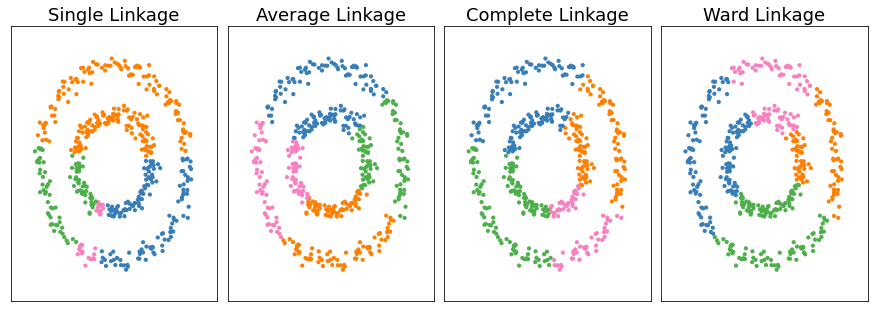

For affinity = euclidean
Metrics for ('Single Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        1.000000
 Completeness       0.763071
 V_measure          0.865616

Metrics for ('Average Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.010608
 Completeness       0.005311
 V_measure          0.007078

Metrics for ('Complete Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.003755
 Completeness       0.001970
 V_measure          0.002584

Metrics for ('Ward Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.001099
 Completeness       0.000559
 V_measure          0.000741



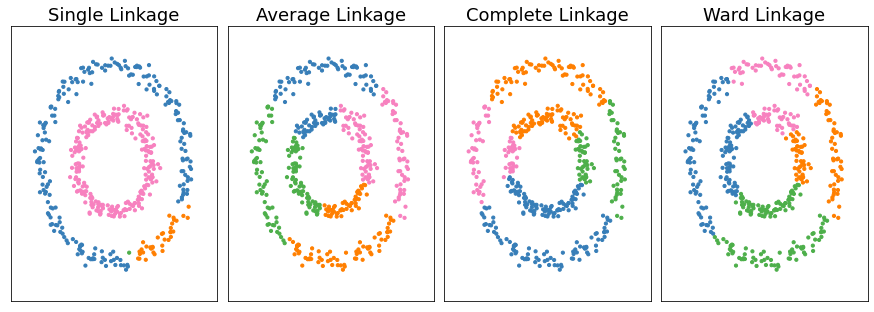

For affinity = manhattan
Metrics for ('Single Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        1.000000
 Completeness       0.763071
 V_measure          0.865616

Metrics for ('Average Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.002268
 Completeness       0.001143
 V_measure          0.001520

Metrics for ('Complete Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.025596
 Completeness       0.013034
 V_measure          0.017273

Metrics for ('Ward Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.001099
 Completeness       0.000559
 V_measure          0.000741



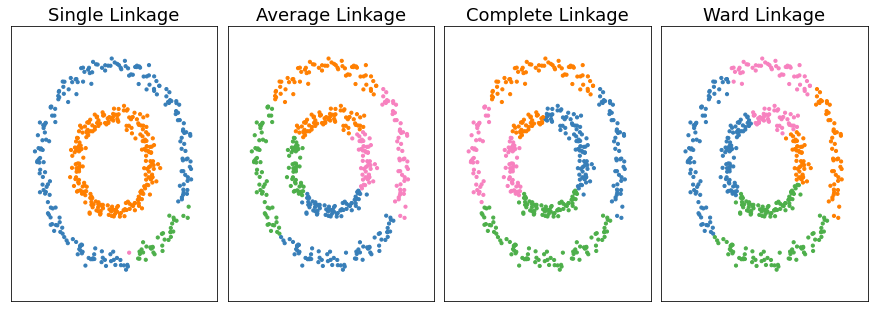

In [6]:
clustering_view(X_circles, y_circles, circles_dataset_len, n_samples, 4)

### Для набору make_blobs:

For affinity = cosine
Metrics for ('Single Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.020448
 Completeness       0.248491
 V_measure          0.037786

Metrics for ('Average Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.448123
 Completeness       0.663203
 V_measure          0.534850

Metrics for ('Complete Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.443398
 Completeness       0.555484
 V_measure          0.493152

Metrics for ('Ward Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.896570
 Completeness       0.896892
 V_measure          0.896731



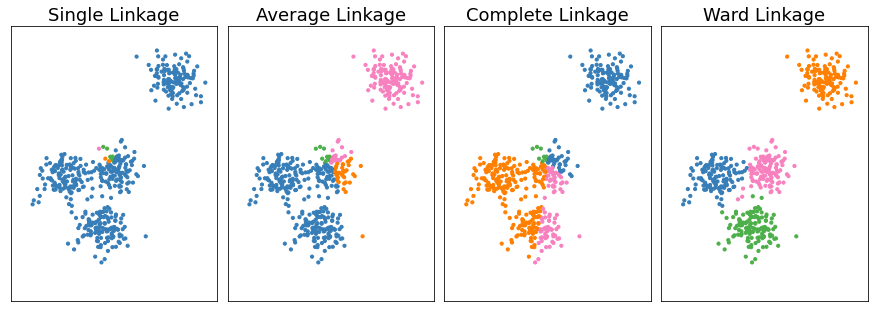

For affinity = euclidean
Metrics for ('Single Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.407228
 Completeness       0.960368
 V_measure          0.571936

Metrics for ('Average Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.911895
 Completeness       0.911927
 V_measure          0.911911

Metrics for ('Complete Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.918905
 Completeness       0.919000
 V_measure          0.918953

Metrics for ('Ward Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.896570
 Completeness       0.896892
 V_measure          0.896731



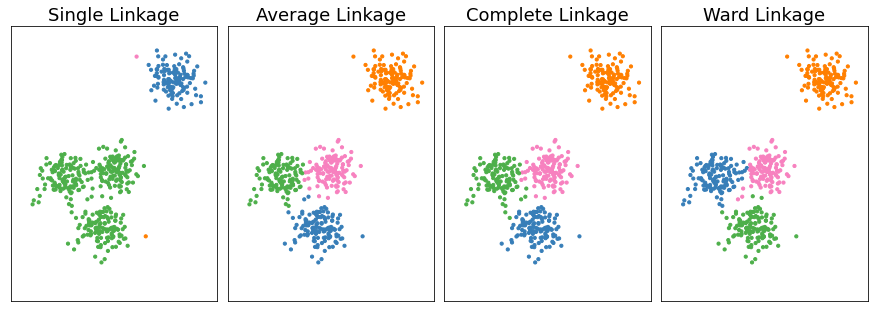

For affinity = manhattan
Metrics for ('Single Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.407228
 Completeness       0.960368
 V_measure          0.571936

Metrics for ('Average Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.946196
 Completeness       0.946500
 V_measure          0.946348

Metrics for ('Complete Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.879048
 Completeness       0.880174
 V_measure          0.879610

Metrics for ('Ward Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.896570
 Completeness       0.896892
 V_measure          0.896731



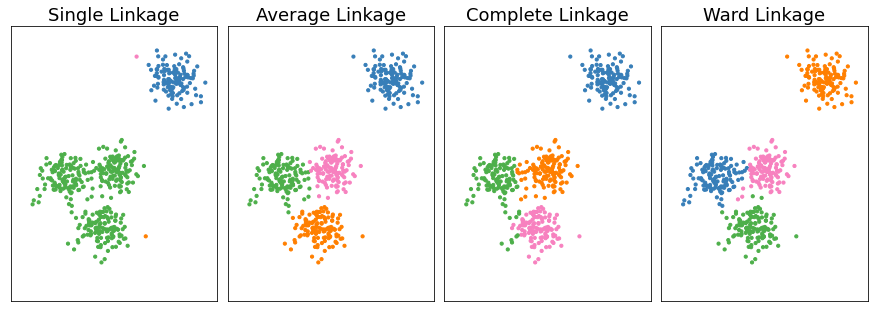

In [7]:
clustering_view(X_blobs,y_blobs, blobs_dataset_len, n_samples, 4)

#### Матриці відстаней для відповідних метрик afinity:

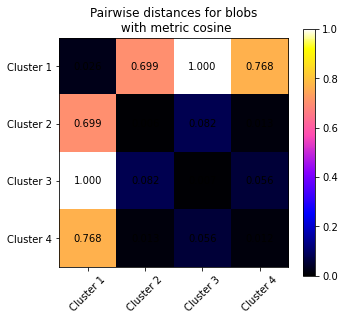

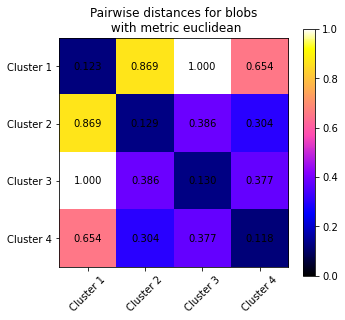

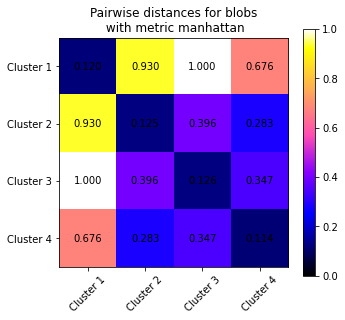

In [8]:
matrics_distances(4, X_blobs, y_blobs, 'blobs')

#### Кластеризація за заданою неправильною кількістю класів - *3*

For affinity = cosine
Metrics for ('Single Linkage', 'cosine')
 Number of Clusters     3
 Homogeneity        0.020448
 Completeness       0.257099
 V_measure          0.037883

Metrics for ('Average Linkage', 'cosine')
 Number of Clusters     3
 Homogeneity        0.364908
 Completeness       0.677541
 V_measure          0.474345

Metrics for ('Complete Linkage', 'cosine')
 Number of Clusters     3
 Homogeneity        0.364928
 Completeness       0.704065
 V_measure          0.480701

Metrics for ('Ward Linkage', 'cosine')
 Number of Clusters     3
 Homogeneity        0.677951
 Completeness       0.898205
 V_measure          0.772689



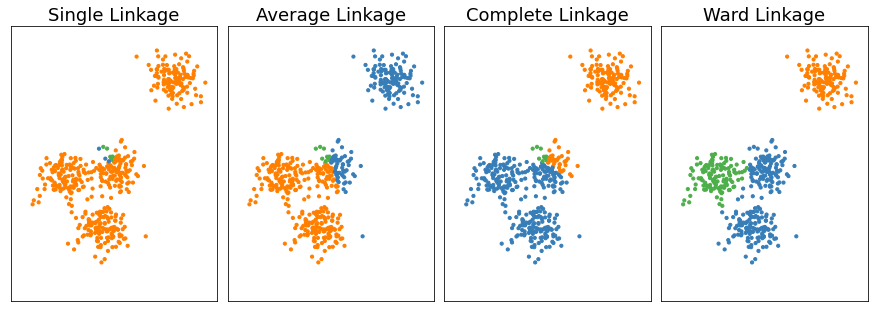

For affinity = euclidean
Metrics for ('Single Linkage', 'euclidean')
 Number of Clusters     3
 Homogeneity        0.407228
 Completeness       0.979783
 V_measure          0.575331

Metrics for ('Average Linkage', 'euclidean')
 Number of Clusters     3
 Homogeneity        0.666386
 Completeness       0.890931
 V_measure          0.762470

Metrics for ('Complete Linkage', 'euclidean')
 Number of Clusters     3
 Homogeneity        0.671931
 Completeness       0.892431
 V_measure          0.766641

Metrics for ('Ward Linkage', 'euclidean')
 Number of Clusters     3
 Homogeneity        0.677951
 Completeness       0.898205
 V_measure          0.772689



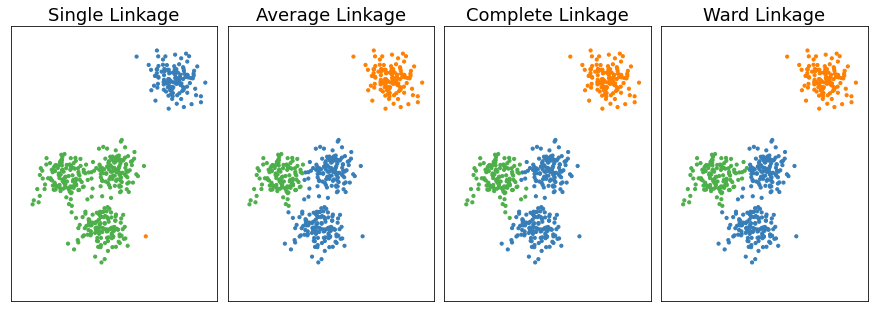

For affinity = manhattan
Metrics for ('Single Linkage', 'manhattan')
 Number of Clusters     3
 Homogeneity        0.407228
 Completeness       0.979783
 V_measure          0.575331

Metrics for ('Average Linkage', 'manhattan')
 Number of Clusters     3
 Homogeneity        0.702208
 Completeness       0.929226
 V_measure          0.799922

Metrics for ('Complete Linkage', 'manhattan')
 Number of Clusters     3
 Homogeneity        0.643381
 Completeness       0.852403
 V_measure          0.733288

Metrics for ('Ward Linkage', 'manhattan')
 Number of Clusters     3
 Homogeneity        0.677951
 Completeness       0.898205
 V_measure          0.772689



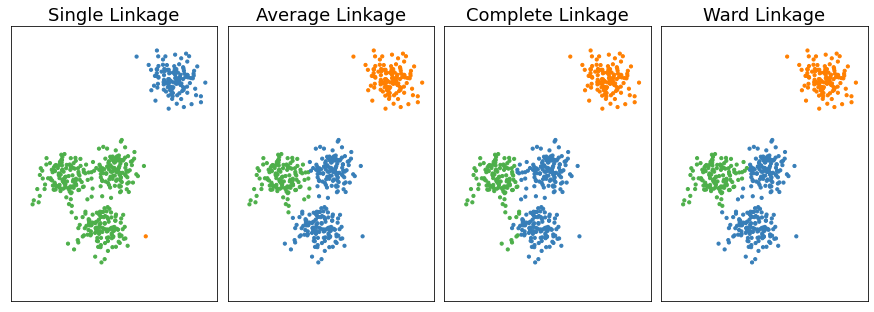

In [9]:
clustering_view(X_blobs,y_blobs, blobs_dataset_len, n_samples, 3)

### Кластеризація з **відсутністю** зміни порядку об'єктів у множині об'єктів
#### Параметр *shuffle* був наданий за замовчуванням у вхідних даних за варіантом

##### Для make_circles

For affinity = cosine
Metrics for ('Single Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000013
 Completeness       0.000015
 V_measure          0.000014

Metrics for ('Average Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000012
 Completeness       0.000012
 V_measure          0.000012

Metrics for ('Complete Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000046
 Completeness       0.000046
 V_measure          0.000046

Metrics for ('Ward Linkage', 'cosine')
 Number of Clusters     2
 Homogeneity        0.000767
 Completeness       0.000788
 V_measure          0.000777



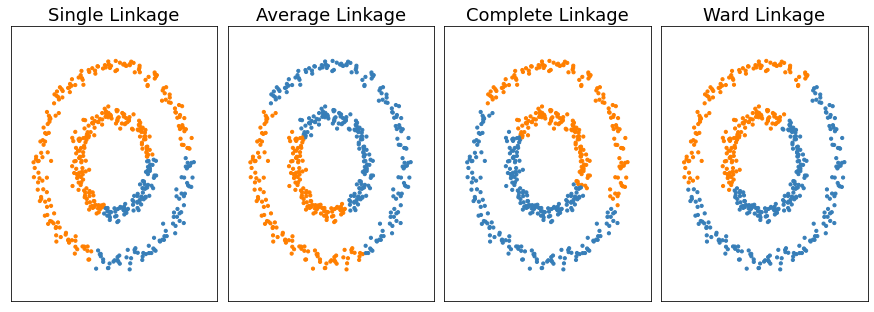

For affinity = euclidean
Metrics for ('Single Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        1.000000
 Completeness       1.000000
 V_measure          1.000000

Metrics for ('Average Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        0.040418
 Completeness       0.043354
 V_measure          0.041834

Metrics for ('Complete Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        0.001965
 Completeness       0.001975
 V_measure          0.001970

Metrics for ('Ward Linkage', 'euclidean')
 Number of Clusters     2
 Homogeneity        0.000767
 Completeness       0.000788
 V_measure          0.000777



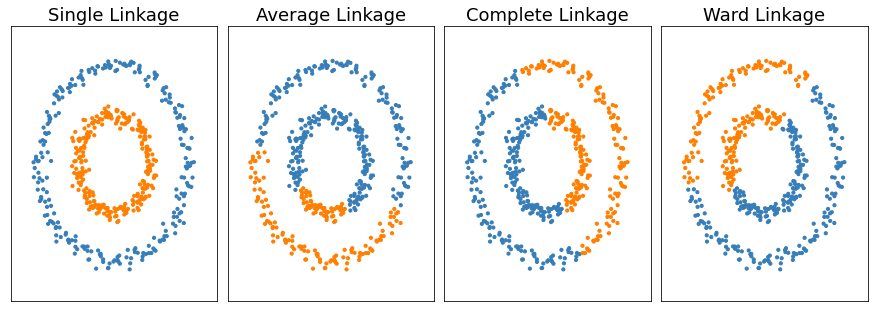

For affinity = manhattan
Metrics for ('Single Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        1.000000
 Completeness       1.000000
 V_measure          1.000000

Metrics for ('Average Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        0.000751
 Completeness       0.000760
 V_measure          0.000756

Metrics for ('Complete Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        0.002617
 Completeness       0.002630
 V_measure          0.002624

Metrics for ('Ward Linkage', 'manhattan')
 Number of Clusters     2
 Homogeneity        0.000767
 Completeness       0.000788
 V_measure          0.000777



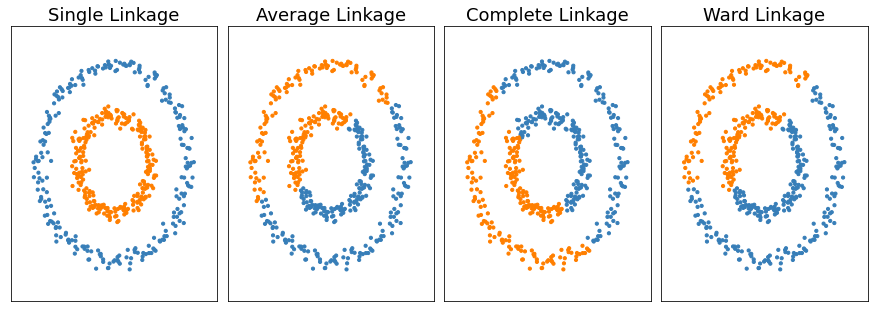

In [10]:
circles_dataset_2 = make_circles(n_samples=n_samples, factor=0.5, shuffle=False, noise=0.05)
X_circles_2, y_circles_2 = circles_dataset_2
circles_dataset_len_2 = len(circles_dataset_2)
clustering_view(X_circles_2, y_circles_2,circles_dataset_len_2, n_samples, 2)

##### Для make_blobs

For affinity = cosine
Metrics for ('Single Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.020448
 Completeness       0.248491
 V_measure          0.037786

Metrics for ('Average Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.448123
 Completeness       0.663203
 V_measure          0.534850

Metrics for ('Complete Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.443398
 Completeness       0.555484
 V_measure          0.493152

Metrics for ('Ward Linkage', 'cosine')
 Number of Clusters     4
 Homogeneity        0.896570
 Completeness       0.896892
 V_measure          0.896731



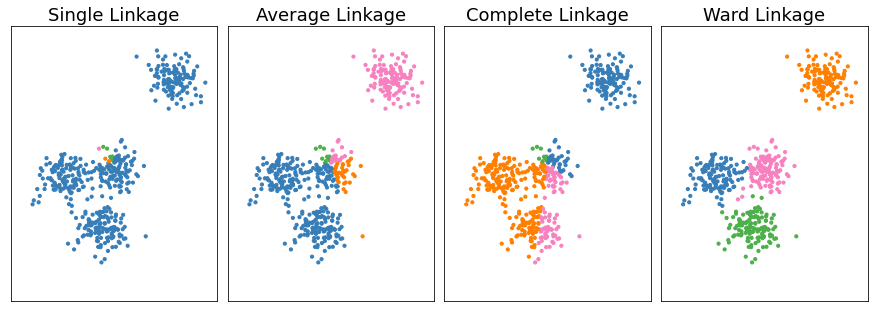

For affinity = euclidean
Metrics for ('Single Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.407228
 Completeness       0.960368
 V_measure          0.571936

Metrics for ('Average Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.911895
 Completeness       0.911927
 V_measure          0.911911

Metrics for ('Complete Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.918905
 Completeness       0.919000
 V_measure          0.918953

Metrics for ('Ward Linkage', 'euclidean')
 Number of Clusters     4
 Homogeneity        0.896570
 Completeness       0.896892
 V_measure          0.896731



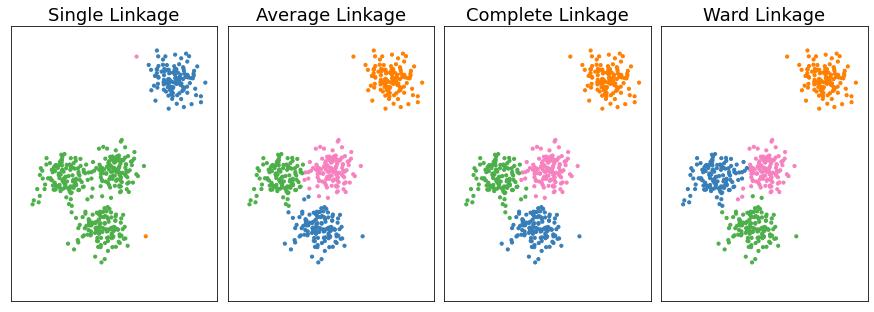

For affinity = manhattan
Metrics for ('Single Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.407228
 Completeness       0.960368
 V_measure          0.571936

Metrics for ('Average Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.946196
 Completeness       0.946500
 V_measure          0.946348

Metrics for ('Complete Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.879048
 Completeness       0.880174
 V_measure          0.879610

Metrics for ('Ward Linkage', 'manhattan')
 Number of Clusters     4
 Homogeneity        0.896570
 Completeness       0.896892
 V_measure          0.896731



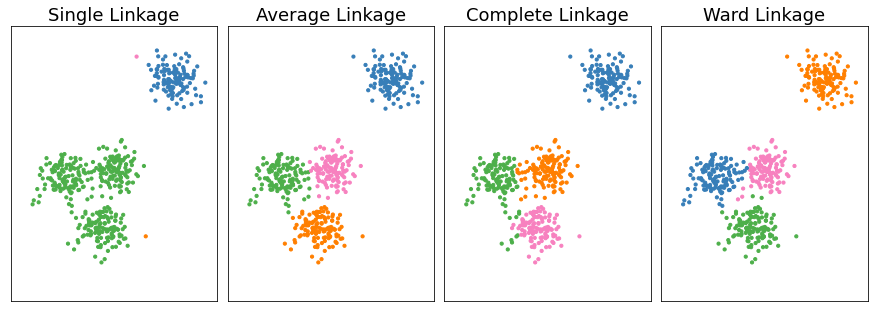

In [11]:
blobs_dataset_2 = make_blobs(n_samples=n_samples, centers=4, cluster_std=1, shuffle=False, random_state=1)
X_blobs_2, y_blobs_2 = blobs_dataset_2
blobs_dataset_len_2 = len(blobs_dataset_2)

clustering_view(X_blobs_2, y_blobs_2, blobs_dataset_len, n_samples, 4)

## Висновки:
#### Алгоритм виявився стабільним по відношенню до перемішування даних. 
#### Вірний результат на наборі make_circles показав з affinity = euclidean та manhattan тільки на критерії linkage = single, оскільки цей критерій працює з некулястими даними.
#### Вірний результат на наборі make_blobs показав з affinity = euclidean та manhattan на критеріях linkage = average, complete та ward, що добре працює на зашумлених даних кулястої форми.
